## Stacked AE

Los stacked AE son el siguiente paso, donde podemos usar mas capas como lo hemos hecho anteriormente con arquitecturas MLP.
La idea original de los AE se mantiene; vamos a desarrollar el encoder y el decoder, solo que esta vez vamos a tener mas capas. Algunas recomendaciones:
- Se debe mantener la simetría en el encoder y decoder.
- Podemos usare varias capas, sin embargo, no se recomienda hacer los modelos muy profundos. Esto causaría que los AE aprendan demasiado bien, eliminando variabilidad generativa.
- Se puede trabajar con múltiples arquitecturas; incluyendo capas convolucionales y RNN. La próxima semana estaremos trabajando con capas convolucionales.


### Stacked Fashion MNIST

El siguiente ejemplo muestra como hacer una arquitectura AE básica para generar imágenes a partir del dataset Fashion MNIST.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# cargar datos
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

#### El Auto Encoder

In [2]:
# funcion de exactitud binaria
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

tf.random.set_seed(42)
np.random.seed(42)

# encoder
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])

# decoder
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

# autoencoder
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

# compilar y entrenar
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3390 - rounded_accuracy: 0.8860 - val_loss: 0.3111 - val_rounded_accuracy: 0.9129
Epoch 2/20
55000/55000 [==============================] - 4s 64us/sample - loss: 0.3059 - rounded_accuracy: 0.9149 - val_loss: 0.3047 - val_rounded_accuracy: 0.9201
Epoch 3/20
55000/55000 [==============================] - 4s 66us/sample - loss: 0.2989 - rounded_accuracy: 0.9212 - val_loss: 0.3034 - val_rounded_accuracy: 0.9118
Epoch 4/20
55000/55000 [==============================] - 4s 65us/sample - loss: 0.2950 - rounded_accuracy: 0.9246 - val_loss: 0.2944 - val_rounded_accuracy: 0.9278
Epoch 5/20
55000/55000 [==============================] - 4s 64us/sample - loss: 0.2924 - rounded_accuracy: 0.9268 - val_loss: 0.2923 - val_rounded_accuracy: 0.9281
Epoch 6/20
55000/55000 [==============================] - 4s 64us/sample - loss: 0.2908 - rounded_accuracy: 0.9281 - val_loss:

#### Mostrar Reconstruccion (prediccion del AE)

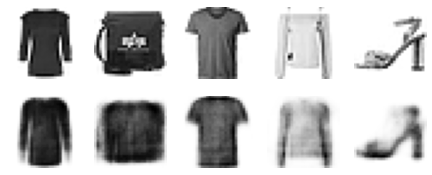

In [3]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, images=X_valid, n_images=5):
    # prediccion de n cantidad de imagenes
    reconstructions = model.predict(images[:n_images])
    # impresion de imagenes vs las generadas
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        

show_reconstructions(stacked_ae)

#### Visualizacion del MNIST con TSNE

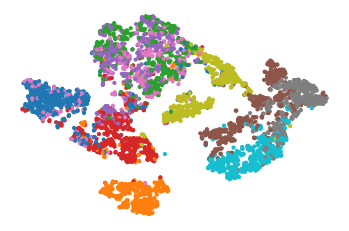

In [4]:
np.random.seed(42)

from sklearn.manifold import TSNE

# como el autoencoder ya esta entrenado, podemos usar solo el encoder si deseamos!
X_valid_compressed = stacked_encoder.predict(X_valid)

# vamos a comprimir el encoder con TSNE
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

# mostrar con matplotlib
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

#### Visualizacion mas bonita!

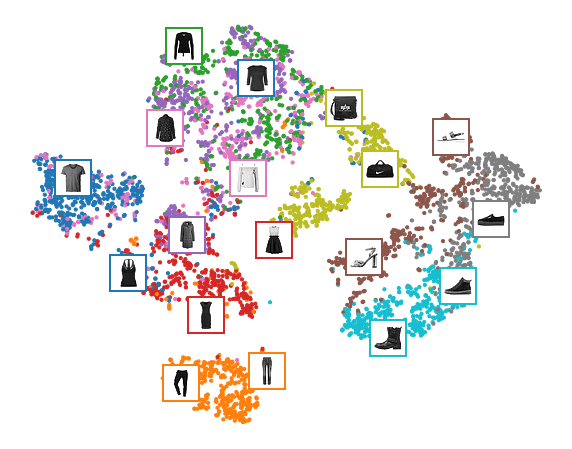

In [5]:
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02:
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()